In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx

In [18]:
total_by_station = pd.read_csv("StationFootfall_Total.csv")

start_weights = total_by_station[['Station', 'EntryTapCount']].copy()
start_weights['StartProb'] = start_weights['EntryTapCount'] / start_weights['EntryTapCount'].sum()

end_weights = total_by_station[['Station', 'ExitTapCount']].copy()
end_weights['EndProb'] = end_weights['ExitTapCount'] / end_weights['ExitTapCount'].sum()

# Monte Carlo simulation of OD pairs
n_samples = 10000

start_stations = np.random.choice(
    start_weights['Station'],
    size=n_samples,
    p=start_weights['StartProb']
    )

end_stations = np.random.choice(
    end_weights['Station'],
    size=n_samples,
    p=end_weights['EndProb']
    )

monte_carlo_routes = pd.DataFrame({'Start': start_stations,'End': end_stations})
# Remove same-origin-destination pairs
monte_carlo_routes = monte_carlo_routes[monte_carlo_routes['Start'] != monte_carlo_routes['End']]

# Get the most popular routes
route_counts = (monte_carlo_routes.value_counts().reset_index(name='Frequency').sort_values(by='Frequency', ascending=False))
route_counts.reset_index(drop=True, inplace=True)
display(route_counts.head(10))

,Start,End,Frequency
0,Kings Cross St Pancras,Victoria,9
1,Oxford Circus,Victoria,9
2,Kings Cross St Pancras,Bank,8
3,Canary Wharf,Kings Cross St Pancras,8
4,Liverpool Street,Stratford,7
5,London Bridge,Kings Cross St Pancras,7
6,Kings Cross St Pancras,Waterloo,7
7,Victoria,Kings Cross St Pancras,7
8,London Bridge,Waterloo,7
9,Oxford Circus,Stratford,7


In [19]:
# Save routes with frequencies for later modelling
route_counts['Start'] = route_counts['Start'].astype(str)
route_counts['End'] = route_counts['End'].astype(str)
route_counts['Route'] = route_counts['Start'] + ' - ' + route_counts['End']
route_counts.to_csv("SimulatedRoute_Frequency.csv", index=False)

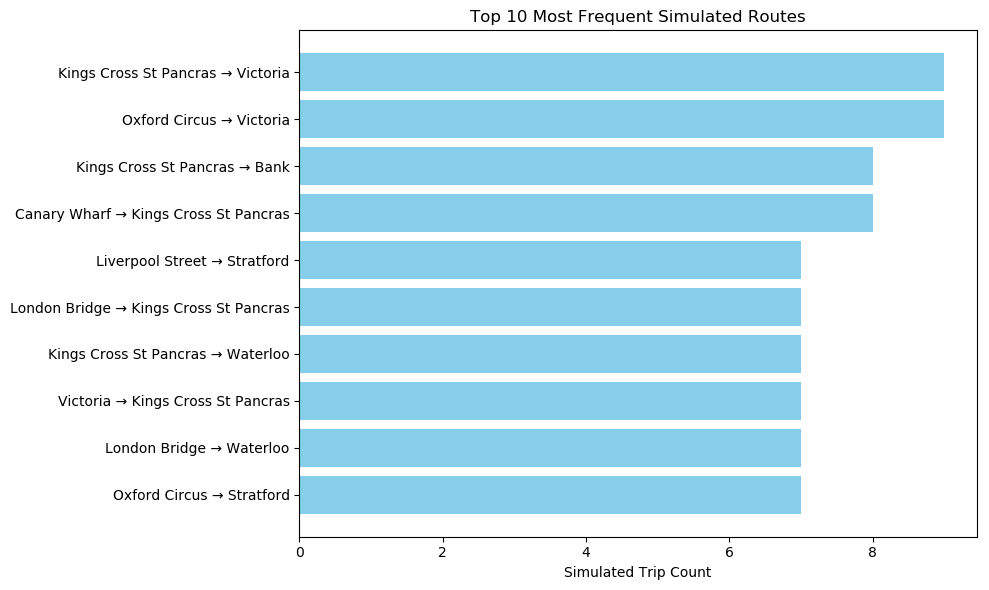

In [20]:
top_routes = route_counts.head(10).copy()
top_routes['Route'] = top_routes['Start'] + ' → ' + top_routes['End']

plt.figure(figsize=(10, 6), dpi=100)
plt.barh(top_routes['Route'][::-1], top_routes['Frequency'][::-1], color='skyblue')
plt.xlabel("Simulated Trip Count")
plt.title("Top 10 Most Frequent Simulated Routes")
plt.tight_layout()
plt.show()

In [21]:
top_routes = route_counts.head(30).copy()

fig = px.sunburst(
    top_routes,
    path=['Start', 'End'],
    values='Frequency',
    color='Frequency',
    color_continuous_scale='Blues',
    title='Top 30 Simulated Routes (Start → End)'
)
fig.update_traces(hovertemplate="<b>From:</b> %{label}<br>" + "<b>Frequency:</b> %{value}<extra></extra>")
fig.update_layout(
    uniformtext=dict(minsize=10),
    margin=dict(t=50, l=10, r=10, b=10)
)
fig.show()

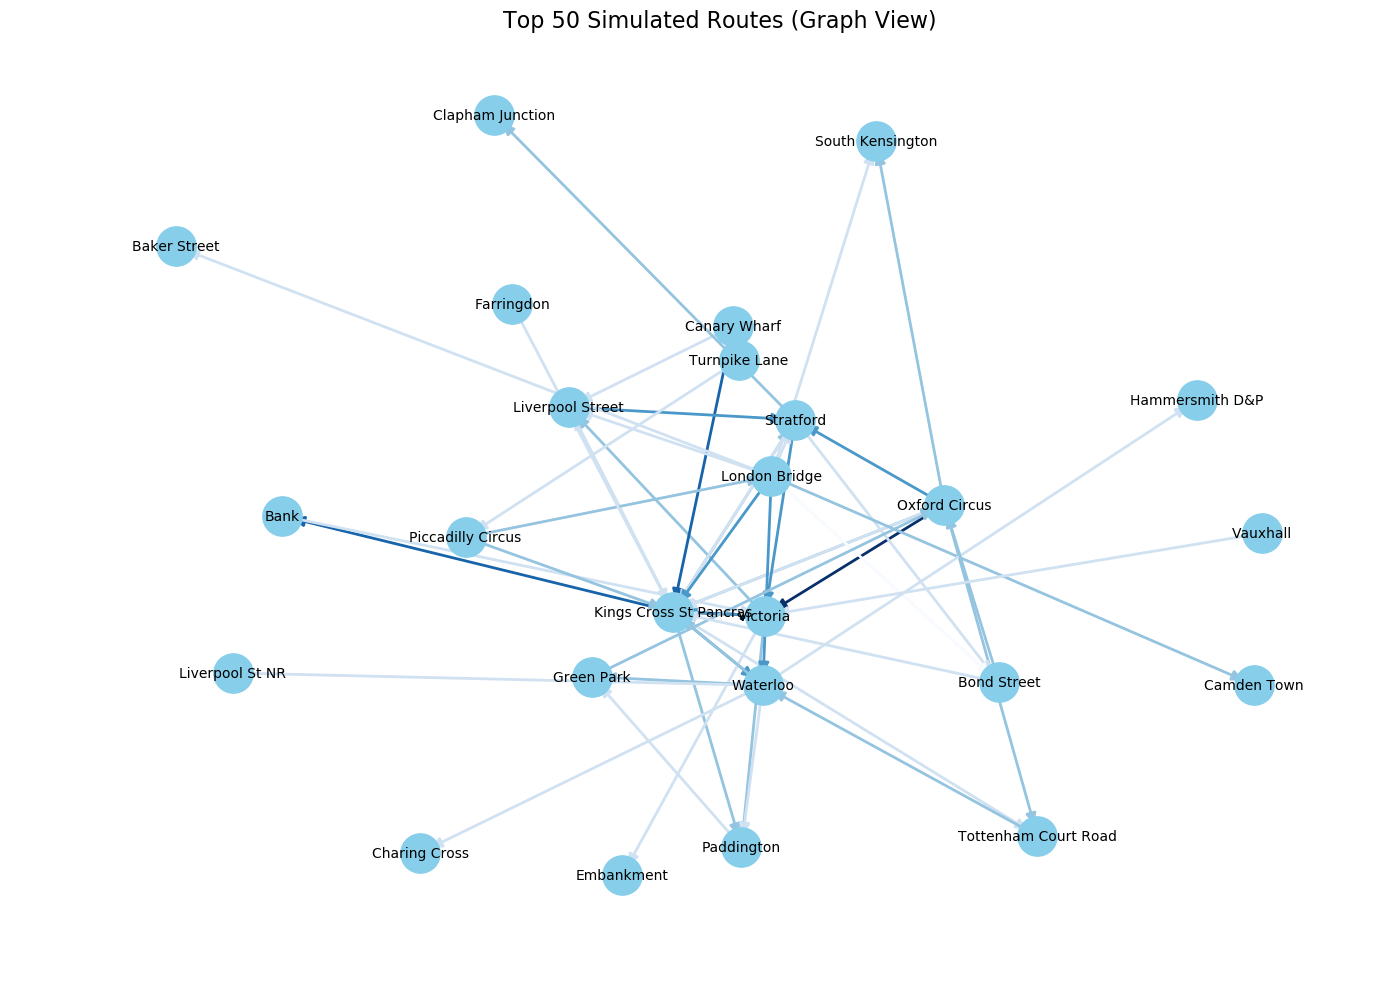

In [22]:
np.random.seed(42)
G = nx.DiGraph()
for _, row in route_counts.head(50).iterrows():
    G.add_edge(row['Start'], row['End'], weight=row['Frequency'])
pos = nx.spring_layout(G, k=1.5)  
edges = G.edges(data=True)
weights = np.array([d['weight'] for (_, _, d) in edges])
weights_norm = (weights - weights.min()) / (weights.max() - weights.min() + 1e-6)

plt.figure(figsize=(14, 10), dpi=100)
nx.draw_networkx_edges(
    G, pos,
    edge_color=weights_norm,
    edge_cmap=plt.cm.Blues,
    width=2,
    alpha=0.6,
    arrows=True,
    arrowsize=15
)

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.title("Top 50 Simulated Routes (Graph View)", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()